In [ ]:
import pandas as pd

# Đọc file CSV đã tải lên
file_path = r"C:\Users\nguye\CODE\TimeSeries\BTL\Thang10_Thang11\User\2019_Data_Cleaned.csv"
df = pd.read_csv(file_path)

# Hiển thị thông tin tổng quan
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170916 entries, 0 to 170915
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     170916 non-null  object 
 1   event_type     170916 non-null  object 
 2   product_id     170916 non-null  int64  
 3   category_id    170916 non-null  int64  
 4   category_code  117174 non-null  object 
 5   brand          135305 non-null  object 
 6   price          170916 non-null  float64
 7   user_id        170916 non-null  int64  
 8   user_session   170916 non-null  object 
 9   churn          170916 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 13.0+ MB


(None,
             event_time event_type  product_id          category_id  \
 0  2019-10-01 09:44:02       view     7005190  2053013560346280633   
 1  2019-10-01 10:05:28       view    28100844  2053013564918072245   
 2  2019-10-01 10:06:22       view    16300056  2053013558131687989   
 3  2019-10-01 10:08:40       view     4200951  2053013552351936731   
 4  2019-10-01 10:09:22       view     4200951  2053013552351936731   
 
                             category_code      brand   price    user_id  \
 0                           kids.carriage    belecoo  183.21  514649263   
 1                                     NaN  moldabela  175.55  516308435   
 2                                     NaN        NaN   14.84  516308435   
 3  appliances.environment.air_conditioner       gree  239.39  516308435   
 4  appliances.environment.air_conditioner       gree  239.39  516308435   
 
                            user_session  churn  
 0  f88e19d3-d6c6-4e8e-ba90-52a7a28f7105      1  
 1  f34

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Tiền xử lý dữ liệu
df["event_time"] = pd.to_datetime(df["event_time"])
df["category_code"] = df["category_code"].fillna("unknown")
df["brand"] = df["brand"].fillna("unknown")

# Thêm các đặc trưng thời gian
df["event_date"] = df["event_time"].dt.date
df["hour"] = df["event_time"].dt.hour
df["dayofweek"] = df["event_time"].dt.dayofweek



In [4]:
# 2. Tổng hợp theo user_session để có dữ liệu gọn cho mô hình học máy
session_df = df.groupby("user_session").agg({
    "event_time": ["min", "max", "count"],
    "event_type": lambda x: x.nunique(),
    "product_id": "nunique",
    "category_code": lambda x: x.mode().iloc[0] if not x.mode().empty else "unknown",
    "brand": lambda x: x.mode().iloc[0] if not x.mode().empty else "unknown",
    "price": ["sum", "mean"],
    "churn": "max"
})

# Làm phẳng MultiIndex
session_df.columns = ['_'.join(col).strip() for col in session_df.columns.values]
session_df.reset_index(inplace=True)




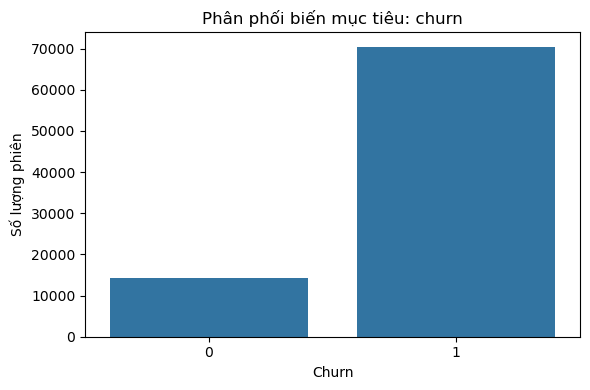

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84622 entries, 0 to 84621
Columns: 770 entries, user_session to brand_<lambda>_zwilling
dtypes: bool(761), datetime64[ns](2), float64(2), int64(4), object(1)
memory usage: 67.2+ MB


In [5]:
# 3. Mã hóa các biến phân loại
session_df = pd.get_dummies(session_df, columns=["category_code_<lambda>", "brand_<lambda>"], drop_first=True)

# 4. Đổi tên cột cho dễ đọc
session_df.rename(columns={
    "event_time_min": "start_time",
    "event_time_max": "end_time",
    "event_time_count": "num_events",
    "event_type_<lambda>": "num_event_types",
    "product_id_nunique": "unique_products",
    "price_sum": "total_spent",
    "price_mean": "avg_price",
    "churn_max": "churn"
}, inplace=True)

# 5. Vẽ biểu đồ phân phối churn
plt.figure(figsize=(6, 4))
sns.countplot(x="churn", data=session_df)
plt.title("Phân phối biến mục tiêu: churn")
plt.xlabel("Churn")
plt.ylabel("Số lượng phiên")
plt.tight_layout()
plt.show()

# Xuất tổng quan dữ liệu sau xử lý
session_df.info()